# Project: App-Review Miner
Team members: Shanshan Li, Yingyezhe Jin, Tianshu Chu, Xiao Huang

### I. Introduction and Problem Statement
The rapid growth of the smartphone market attracts increasing groups of developers to build mobile applications (Apps)  that are reforming our daily life. Given the keen competitions among apps and violently evolving of user preference, developers could no longer act blindly. They often prefer to put apps online first and then iteratively improve apps based on feedback. The timely informative interactions could not only help develops debug more efficiently, but also often reflect user preference. Developers could leverage them as a key guidance to improve the user experience. Unlike other commercial software that relies more on traditional channels such as crashing reports, emails, bug repositories and online forums, mobile apps have a special rich interactive information source, i.e., reviews and ratings in app marketplaces such as Google Play and App Store.

** Challenges. **
Given the extensive reviews available, however, it is not a trivial task to mine the informative user feedback from them, i.e., app-review miner. There are two major challenges. First, there is no clear definition of informative reviews. For different types of apps, informative feedback could be diverse. Even for app developers, they may all have different understandings of informative. Second, the number of reviews could be in large-scale, especially for the popular apps. It is impossible to tackle these reviews manually. Moreover, the informative reviews only occupy a small proportion of the total. Motivated by the work of [1], in this project, we implement an app-review miner to extract informative reviews for developers from app marketplace. 

** Research Problem Definition. **
We formally define the app-review miner problem as follows. A review is defined as “informative” if it contains information that app developers are looking to identify and is potentially useful for improving the quality or user experience. Given a set of reviews and corresponding ratings of an app, with only a small proportion of reviews have labels indicating informative or not, we aim to find all the informative reviews, and rank them according to the importance to developers.

### II. Related Work
The literature has covered two main categories of related work, i.e., app market analysis and user review analysis. First, it has been pointed out that mobile app marketplaces are different than traditional ones from various aspects such as technical, customer, business, and APIs [5,6]. Few efforts have been devoted to utilizing user reviews in Marketplaces. Carreno and Winbladh explored a topic learning framework for requirement changes based on sentiment analysis. Fu et al. [7] focused on analyzing users’ dissatisfaction by modeling the relationship of the negative reviews and the development of an app. Second, many efforts have been devoted to investigating user reviews of traditional marketplaces such as movies and commodity goods based on sentiment analysis [8]. The key idea is to learn the emotional features in reviews and classifies them into “positive” and “negative” classes. However, existing methods cannot be directly applied to our problem. We also need to rank the reviews according to the importance to save developers’ efforts. Another well-studied related topic is spam detection [9], whose methods can be utilized in our project to filter out spammy reviews.

### III. Proposed App-Review Miner Framework

To address the app-review miner problem, we implement an automated review analysis framework - App-Review Miner. It contains four major components, i.e., ** 1. NLP based preprocessing -> 2. Naive Bayes based filtering -> 3. LDA topic modeling based grouping -> 4. Ranking algorithms for importance**. First, we use natural language processing (NLP) techniques such as tokenization, stemming, and casefolding to preprocess the raw user review data into a well-structured format. Second, to filter out non-informative reviews automatically, we train a classifier with Expectation Maximization for Naive Bayes (EMNB) [2]. Third, we group the remaining “informative” reviews through Latent Dirichlet Allocation (LDA) [3] topic modeling algorithm, in such a way that reviews in the same group are more semantically similar to each other than those in other groups. Fourth, we learn different non-trivial features for groups and reviews in each group, and prioritize them according to their level of importance. In the end, we also visualize the ranking results of all valuable information and present an intuitive summary report to app developers.

**Datasets:** The original ones from the work of [1]. https://sites.google.com/site/appsuserreviews/ They are the user reviews of four apps from Google Play, i.e., SwiftKey Keyboard, Facebook, Temple Run 2, and Tap Fish, with time period from Oct, 2012 to Feb, 2013.

**1. NLP based preprocessing component**

     Inputs: datasetName
             rmStopWords control to remove stop words
             rmRareWords control to remove rarely occured words
             
    Outputs: trainSet    is a list of training reviews
             testSet     is a list of testing reviews
             unlabelSet  is a list of unlabeld reviews
             vocabulary  is the corresponding n vocabulary in a dictionary form {word, index}

In [91]:
%run ./AR_util.py
%run ./AR_reviewInstance.py
datasetName = "swiftkey" # four apps : facebook, templerun2, swiftkey, tapfish

rmStopWords = True # Removing stop words lead to information loss and bad f-score
rmRareWords = True

# trainSet/testSet/unlabel: dictionary of {label, reviews} for review data
# vocabulary: dictionary len = V and the positional index of each term in the doc vector
# set skParse True to directly read of the data that has been filtered out
skParse = False
if(skParse == False):
    # the vocabulary is the words on the training set!
    trainSet, testSet, unlabelSet, vocabulary = AR_parse(datasetName, rmStopWords, rmRareWords)

Vocabulary size for swiftkey : 1709
Training set Size: 1000
Testing set Size: 2000
Unlabeling set Size: 3282


### Naive Bayes based filtering

    Inputs:  train/test/unlabelSet   are the preprocessed reviews 
             vocabulary              is the corresponding vocabulary of the reviews
    Outputs: informMat    is a k*m np sparse matrix, k is the number of informative reviews, m is the length of vocabulary
             informRev    is a list of informative reviews

In [92]:
%run ./AR_classifier.py
# 1. Use the EM-NB or SVM to filter out the informative reviews
# informMat: the informative reviews in X x V sparse matrix from, X: documents size, V: vocabulary size
# informRev: corresponding reviews wrapped as a list of review instances
useSVM = True # SVM is way better than emnb in terms of the testing. 
               # But it may not filter out the information effectively
if(skParse == False):
    if(useSVM == False):
        informRev, informMat = AR_emnb(trainSet, testSet, unlabelSet, vocabulary, datasetName)
    else:
        informRev, informMat = AR_svm(trainSet, testSet, unlabelSet, vocabulary, datasetName)

    # write the result back to the file (optional)
    AR_writeReviews(informRev, datasetName)
else:
    # directly read from the file
    informRev, informMat, vocabulary = AR_loadReviews(datasetName)

print("Number of informative reviews: " + str(len(informRev)))

Average F-Score for the test data: 0.79566013565
Number of informative reviews: 788


### LDA topic clustering

    Inputs:  informMat  is the k*m np sparse matrix, k is the number of informative reviews, m  is the length of vocabulary
             informRev  is the informative review list
             vocabulary is the corresponding vocabulary dictionary
             n_topics   is the number of topics
    Outputs: doc_topic  is a k*n_topics np matrix, which indicates the probability
             vocab      is the vocabulary in the list form

In [93]:
%run ./AR_lda.py
# 2. Use the LDA to do the grouping based on the topic
# doc_topi : a k*n_topics np matrix, which indicates the probability of each review belongs to one of the topic
# vocab: a list of vocabulary words
n_topics = 20
doc_topic, vocab, top_words_list = AR_lda(informRev, informMat, vocabulary, n_topics)

INFO:lda:n_documents: 788
INFO:lda:vocab_size: 1709
INFO:lda:n_words: 6357
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -74057
INFO:lda:<500> log likelihood: -44293
INFO:lda:<999> log likelihood: -43855


Topic 0: text type lag messag close back select
Topic 1: keyboard wish could custom type set better
Topic 2: space also punctuat insert period bar add
Topic 3: word sometim predict sentenc letter middl place
Topic 4: support chines languag pleas input japanes soon
Topic 5: keyboard time everi phone updat default set
Topic 6: use seem phone well bit like quit
Topic 7: work predict correct email browser auto address
Topic 8: would option dictionari star add custom give
Topic 9: keyboard swiftkey need samsung galaxi stock note
Topic 10: theme add would wish nice like new
Topic 11: app crash time make issu chrome caus
Topic 12: need swype thing featur wish emoji miss
Topic 13: get languag download pack error english cannot
Topic 14: keyboard button need great option still good
Topic 15: like would one key love keyboard app
Topic 16: key press option long pleas new swift
Topic 17: word type delet suggest swipe remov want
Topic 18: updat get one thing lack come sure
Topic 19: word use predic

In [5]:
"""
doc_topic = model.doc_topic_
ClustNum = []
# print doc_topic[1]
for i in range(k):
    ClustNum.append(doc_topic[i].argmax())
print ClustNum
"""

'\ndoc_topic = model.doc_topic_\nClustNum = []\n# print doc_topic[1]\nfor i in range(k):\n    ClustNum.append(doc_topic[i].argmax())\nprint ClustNum\n'

### Ranking all the groups based on importance

    Inputs:  doc_topic      is a k*n_topics np matrix, which indicates the probability
             wg             is a row vector (1 * 2), where each element denotes the weight of the corresponding feature
             informRev      is the informative review list
    Outputs: group_scores   is a row vector (1 * 20), where each element is the score of the corresponding group
             sorted_indices is a row vector (1 * 20), where the ith element is the index of the group whose score is the ith largest

In [94]:
%run ./AR_ranker.py
wg = [0.85, 0.15]
group_scores, sorted_group_indices = group_rank(doc_topic, wg, informRev)
print('group scores:\n')
print(group_scores)
print('ranked indices:\n')
print(sorted_group_indices)

group scores:

[44.61356029001, 40.915252440197307, 39.750179604185199, 37.84656172982708, 35.491508934233906, 34.74795673927742, 34.115943916016931, 34.069437790839224, 32.898616178678111, 32.894511955269913, 31.808817952424224, 31.464395418330426, 30.879514095307119, 30.841634804661489, 30.760607277727303, 30.571929162235659, 30.34780558693674, 30.021913274847485, 28.839138305928852, 27.769614590625949]
ranked indices:

[10, 8, 5, 4, 7, 12, 6, 15, 13, 19, 2, 9, 0, 16, 17, 1, 14, 18, 11, 3]


### Cluster the reviews using volume and use TextRank to rank each instance

    Inputs:  doc_topic  is a np matrix k*n_topic, where k is # of reviews
             informRev  is a list of all informative reviews
    Outputs: rankedInstance is a dict = {topic, list of ranked reviews with the score}

In [95]:
%run ./AR_textrank.py
AR_tfIdf(informRev)
rankedInstance = AR_textrank(doc_topic, informRev)

In construct the graph of reviews ---- Nodes: 42 Edges: 20
In construct the graph of reviews ---- Nodes: 37 Edges: 22
In construct the graph of reviews ---- Nodes: 47 Edges: 58
In construct the graph of reviews ---- Nodes: 35 Edges: 10
In construct the graph of reviews ---- Nodes: 60 Edges: 326
In construct the graph of reviews ---- Nodes: 51 Edges: 124
In construct the graph of reviews ---- Nodes: 37 Edges: 12
In construct the graph of reviews ---- Nodes: 46 Edges: 60
In construct the graph of reviews ---- Nodes: 55 Edges: 100
In construct the graph of reviews ---- Nodes: 38 Edges: 26
In construct the graph of reviews ---- Nodes: 67 Edges: 230
In construct the graph of reviews ---- Nodes: 27 Edges: 12
In construct the graph of reviews ---- Nodes: 35 Edges: 54
In construct the graph of reviews ---- Nodes: 34 Edges: 110
In construct the graph of reviews ---- Nodes: 31 Edges: 4
In construct the graph of reviews ---- Nodes: 35 Edges: 14
In construct the graph of reviews ---- Nodes: 33 Edg

In [96]:
# print the top 10 reviews:
for i in range(len(rankedInstance)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = rankedInstance[i][j][0]
        score = rankedInstance[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: sometimes the auto correct feature doesn t appear and i have to exit the text message and re open it for it to appear Score: 0.0549449889073
2th review Text: keeps crashing when trying to tag posts on tumblr app Score: 0.0549449889073
3th review Text: it would be great if there s undo cut copy paste buttons and a swype support Score: 0.0549449889073
4th review Text: like it most the time but so sick of it crashing when i copy paste or even selecting text can cause it Score: 0.0549449889073
5th review Text: like just about every aspect other than that the keyboard lags when i type fast and occasionally freezes for a few seconds at a time Score: 0.0549449889073
Instance review for topic group: 1
1th review Text: the only thing i could think to suggest is custom colored keyboard themes Score: 0.0479615943544
2th review Text: my only wish would be that the typing field could be skinned to match the keyboard theme Score: 0.0479615943544
3t

### Ranking all the reviews in each group based on their importance score

    Inputs: doc_topic             is a k*n_topics np matrix, which indicates the probability
            weight                is a row vector (1 * 3), where each element denotes the weight of the corresponding feature
    Outputs: topic_top10RevScores is a row vector (10 * 20), where each element is the ranked score of the corresponding review in each group

In [97]:
%run ./AR_reviewRanking.py
AR_tfIdf(informRev)
weight = [0.25, 0.25, 0.25, 0.25]
topic_top10RevScores = instance_ranking(doc_topic, weight, informRev)

Length of 0th topic has reviews: 51
Length of 1th topic has reviews: 51
Length of 2th topic has reviews: 55
Length of 3th topic has reviews: 46
Length of 4th topic has reviews: 77
Length of 5th topic has reviews: 78
Length of 6th topic has reviews: 60
Length of 7th topic has reviews: 68
Length of 8th topic has reviews: 85
Length of 9th topic has reviews: 56
Length of 10th topic has reviews: 92
Length of 11th topic has reviews: 52
Length of 12th topic has reviews: 64
Length of 13th topic has reviews: 48
Length of 14th topic has reviews: 55
Length of 15th topic has reviews: 72
Length of 16th topic has reviews: 58
Length of 17th topic has reviews: 53
Length of 18th topic has reviews: 50
Length of 19th topic has reviews: 63


In [98]:
# print the top 10 reviews:
for i in range(len(topic_top10RevScores)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = topic_top10RevScores[i][j][0]
        score = topic_top10RevScores[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: klavesnica castokrat zadava velke pismena a v v strede vety a 9 mb zabera v internej pamati co je pre mna dost vela Score: 0.7025
2th review Text: lags while typing Score: 0.669444444444
3th review Text: horrible lag that message took 5 minutes to type Score: 0.659375
4th review Text: constant problems typing inserts random letters pre selects words i don t want even sends texts before i m finished Score: 0.5953125
5th review Text: we also want custom gestures paste select all move cursor etc and changeable detection sensitivity Score: 0.578846153846
Instance review for topic group: 1
1th review Text: needs more settings so i can personalize the keyboard Score: 0.697222222222
2th review Text: there is a ton if lag Score: 0.69375
3th review Text: extremely inaccurate when texting i hate this keyboard wish i could have refund Score: 0.6275
4th review Text: wish i could get my money back Score: 0.610714285714
5th review Text: but since i

### Visualization

    Inputs:  group_scores is a list of scores of each group
    Outputs: a radar chart

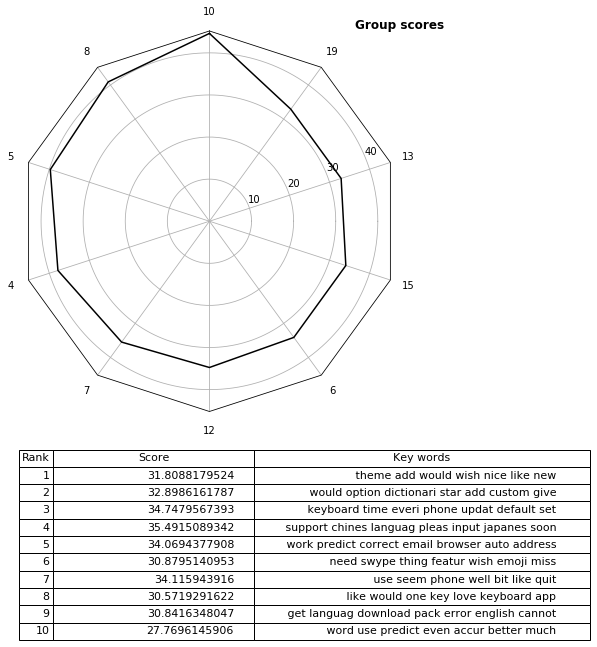

In [99]:
%run ./AR_visualization.py

group_count = 10
plot_group_ranking(group_scores, sorted_group_indices, top_words_list, group_count)

### VI. References:
[1] Chen, Ning, et al. "AR-miner: mining informative reviews for developers from mobile app marketplace." ICSE, 2014.

[2] K. Nigam, A. K. McCallum, S. Thrun, and T. Mitchell. Text classification from labeled and unlabeled documents using EM. Mach. Learn., 39(2-3):103–134, 2000.

[3] D. M. Blei, A. Y. Ng, and M. I. Jordan. Latent dirichlet allocation. J. Mach. Learn. Res., 3:993–1022, 2003.

[4] B. Croft, D. Metzler, and T. Strohman. Search Engines: Information Retrieval in Practice. Addison-Wesley Publishing Company, USA, 1st edition, 2009.

[5] M. Harman, Y. Jia, and Y. Zhang. App store mining and analysis: Msr for app stores. In Proceedings of the 9th Working Conference on Mining Software Repositories, pages 108–111, 2012.

[6] R. Minelli and M. Lanza. Software analytics for mobile applications–insights & lessons learned. CSMR, 2013.

[7] B. Fu, J. Lin, L. Li, C. Faloutsos, J. Hong, and N. Sadeh. Why people hate your app: Making sense of user feedback in a mobile app store. KDD, pages 1276–1284, 2013.

[8] B. Pang and L. Lee. Opinion mining and sentiment analysis. Found. Trends Inf. Retr., 2:1–135, 2008.

[9] C.-F. Hsu, E. Khabiri, and J. Caverlee. Ranking comments on the social web. International Conference on Computational Science and Engineering, pages 90–97, 2009.

[10] L. V. Galvis Carreno and K. Winbladh. Analysis of user comments: An approach for software requirements evolution. ICSE, pages 582–591, 2013.